# ***Genetic Variant Classification***

## *Problem Description*

The dataset for this project originates from ClinVar. ClinVar is a public resource containing annotations about human genetic variants. These variants are classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic.



<img src=https://blueprintgenetics.com/app/uploads/2016/02/Scheme_-e1463643817318.jpg width="500">



### *Objective*

Predict whether a ClinVar variant will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.

### *What is considered a conflicting classification?*

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

* Likely Benign or Benign
* VUS
* Likely Pathogenic or Pathogenic

Conflicting classification has been assigned to the CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.



### *What is a genetic variant?*

A change in a gene also called gene mutation. These mutations range from benign to pathogenic.



### *Why it's important?*

Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

### *View Data*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DMProject/clinvar_conflicting.csv")
display(df)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,38,40) have mixed types.Specify dtype option on import or set low_memory=False.



,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,CLNDNINCL,CLNHGVS,CLNSIGINCL,CLNVC,CLNVI,MC,ORIGIN,SSR,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,INTRON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,DISTANCE,STRAND,BAM_EDIT,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.1168180G>C,NaN,single_nucleotide_variant,UniProtKB_(protein):Q96L58#VAR_059317,SO:0001583|missense_variant,1,NaN,0,C,missense_variant,MODERATE,B3GALT6,Transcript,NM_080605.3,protein_coding,1/1,NaN,552,522,174,E/D,gaG/gaC,NaN,1.0,NaN,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,NaN,NC_000001.10:g.1470752G>A,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:616101.0001|UniProtKB_(pr...,SO:0001583|missense_variant,1,NaN,0,A,missense_variant,MODERATE,TMEM240,Transcript,NM_001114748.1,protein_coding,4/4,NaN,523,509,170,P/L,cCg/cTg,NaN,-1.0,OK,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,NaN,NC_000001.10:g.1737942A>G,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:139380.0002|UniProtKB_(pr...,"SO:0001583|missense_variant,SO:0001623|5_prime...",35,NaN,1,G,missense_variant,MODERATE,GNB1,Transcript,NM_002074.4,protein_coding,6/12,NaN,632,239,80,I/T,aTc/aCc,NaN,-1.0,OK,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,NaN,NC_000001.10:g.2160305G>A,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:164780.0004|UniProtKB_(pr...,SO:0001583|missense_variant,33,NaN,0,A,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,1/7,NaN,132,100,34,G/S,Ggc/Agc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,NaN,NC_000001.10:g.2160305G>T,NaN,single_nucleotide_variant,OMIM_Allelic_Variant:164780.0005|UniProtKB_(pr...,SO:0001583|missense_variant,33,NaN,0,T,missense_variant,MODERATE,SKI,Transcript,XM_005244775.1,protein_coding,1/7,NaN,132,100,34,G/C,Ggc/Tgc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,X,154158201,T,G,0.0801,0.13923,0.1605,"MedGen:C0019069,OMIM:306700,SNOMED_CT:28293008...",NaN,Hereditary_factor_VIII_deficiency_disease|not_...,NaN,NC_000023.10:g.154158201T>G,NaN,single_nucleotide_variant,"ARUP_Laboratories,_Molecular_Genetics_and_Geno...",SO:0001819|synonymous_variant,1,NaN,0,G,synonymous_variant,LOW,F8,Transcript,NM_000132.3,protein_coding,14/26,NaN,4035,3864,1288,S,tcA/tcC,NaN,-1.0,OK,NaN,NaN,NaN,NaN,NaN,NaN,0.00158,0.105,-0.630908,NaN
65184,X,154159118,C,T,0.0020,0.00060,0.0013,MedGen:CN169374|MedGen:CN239152,NaN,"not_specified|Hemophilia_A,_FVIII_Deficiency",NaN,NC_000023.10:g.154159118C>T,NaN,single_nucleotide_variant,"ARUP_Laboratories,_Molecular_Genetics_and_Geno...",SO:0001583|missense_variant,1,NaN,1,T,missense_variant,MODERATE,F8,Transcript,NM_000132.3,protein_coding,14/26,NaN,3118,2947,983,V/I,Gta/Ata,NaN,-1.0,OK,tolerated,benign,NaN,NaN,NaN,NaN,0.00158,0.002,-1.731470,3.0
65185,X,154194886,C,T,0.0125,0.00370,0.0111,MedGen:CN169374|MedGen:CN239152,NaN,"not_specified|Hemophilia_A,_FVIII_Deficiency",NaN,NC_000023.10:g.154194886C>T,NaN,single_nucleotide_variant,"ARUP_Laboratories,_Molecular_Genetics_and_Geno...",SO:0001819|synony

In [ ]:
df.dtypes

CHROM                  object
POS                     int64
REF                    object
ALT                    object
AF_ESP                float64
AF_EXAC               float64
AF_TGP                float64
CLNDISDB               object
CLNDISDBINCL           object
CLNDN                  object
CLNDNINCL              object
CLNHGVS                object
CLNSIGINCL             object
CLNVC                  object
CLNVI                  object
MC                     object
ORIGIN                  int64
SSR                   float64
CLASS                   int64
Allele                 object
Consequence            object
IMPACT                 object
SYMBOL                 object
Feature_type           object
Feature                object
BIOTYPE                object
EXON                   object
INTRON                 object
cDNA_position          object
CDS_position           object
Protein_position       object
Amino_acids            object
Codons                 object
DISTANCE  

In [ ]:
df.describe()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,SSR,CLASS,DISTANCE,STRAND,MOTIF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
count,6.518800e+04,65188.000000,65188.000000,65188.000000,65188.000000,130.000000,65188.000000,108.000000,65174.000000,2.0,2.000000,60975.000000,64096.000000,64096.000000,25593.000000
mean,7.757594e+07,0.014511,0.014492,0.015263,1.342486,2.269231,0.252102,825.731481,-0.006659,1.0,-0.080000,0.345058,15.685616,2.554131,-0.402258
std,5.974051e+07,0.057795,0.059542,0.059527,5.688772,4.190777,0.434223,1069.363315,0.999985,0.0,0.024042,0.361238,10.836350,2.961553,1.872684
min,9.610000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,1.0,-0.097000,0.000069,0.001000,-5.477391,-3.000000
25%,3.254179e+07,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,55.500000,-1.000000,1.0,-0.088500,0.024300,7.141000,0.462951,-2.000000
50%,5.797021e+07,0.000000,0.000040,0.000000,1.000000,1.000000,0.000000,469.000000,-1.000000,1.0,-0.080000,0.157000,14.090000,1.642948,-1.000000
75%,1.127454e+08,0.001200,0.001230,0.001600,1.000000,1.000000,1.000000,1415.000000,1.000000,1.0,-0.071500,0.710000,24.100000,4.381392,1.000000
max,2.476080e+08,0.499000,0.499890,0.499800,513.000000,16.000000,1.000000,4759.000000,1.000000,1.0,-0.063000,1.000000,99.000000,46.556261,3.000000


Looking at the class distribution, it's easy to notice that we have class imbalance.

In [ ]:
df['CLASS'].value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

Text(0.5, 1.0, 'Benign vs. Pathogenic Class Count\n')

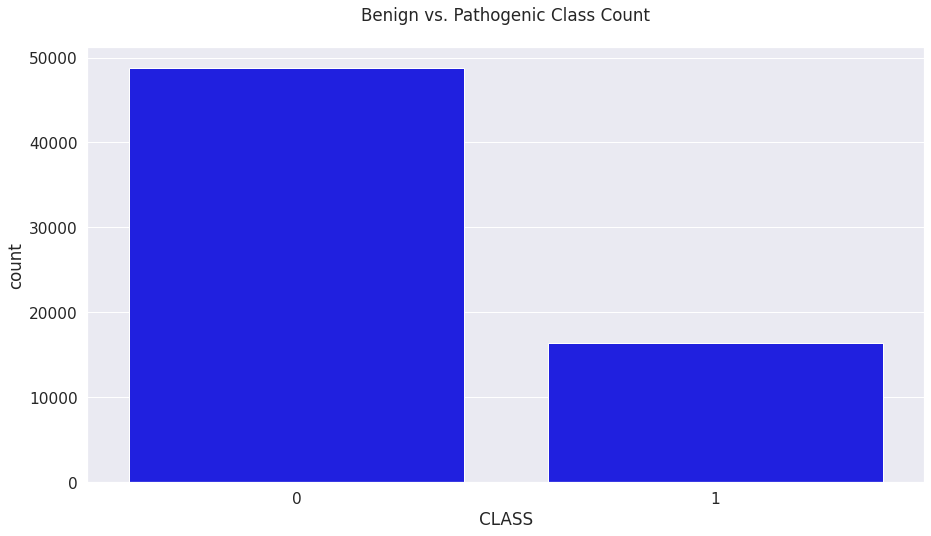

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)

sns.countplot(x = 'CLASS', data = df, color = 'blue').set_title('Benign vs. Pathogenic Class Count\n')

# plot = df['CLASS'].value_counts().plot(kind = 'bar', color = 'blue');


## *Data Cleaning*

### *Missing Values*

In [ ]:
df_nulls = df[df.columns[df.isnull().any()]]
msng = df_nulls.isnull().sum()
msng

CLNDISDBINCL          65021
CLNDNINCL             65021
CLNSIGINCL            65021
CLNVI                 37529
MC                      846
SSR                   65058
SYMBOL                   16
Feature_type             14
Feature                  14
BIOTYPE                  16
EXON                   8893
INTRON                56385
cDNA_position          8884
CDS_position           9955
Protein_position       9955
Amino_acids           10004
Codons                10004
DISTANCE              65080
STRAND                   14
BAM_EDIT              33219
SIFT                  40352
PolyPhen              40392
MOTIF_NAME            65186
MOTIF_POS             65186
HIGH_INF_POS          65186
MOTIF_SCORE_CHANGE    65186
LoFtool                4213
CADD_PHRED             1092
CADD_RAW               1092
BLOSUM62              39595
dtype: int64

In [ ]:
percentage_missing = df.isnull().sum().apply(lambda x: x/df.shape[0]*100)
missing_values_perc = pd.DataFrame({'Number of Missing':  msng,
                             'Percentage of Missing': percentage_missing})
missing_values_perc.dropna(inplace = True)
display(missing_values_perc.sort_values(ascending = False, by = 'Percentage of Missing'))

,Number of Missing,Percentage of Missing
MOTIF_POS,65186.0,99.996932
MOTIF_SCORE_CHANGE,65186.0,99.996932
MOTIF_NAME,65186.0,99.996932
HIGH_INF_POS,65186.0,99.996932
DISTANCE,65080.0,99.834325
SSR,65058.0,99.800577
CLNDISDBINCL,65021.0,99.743818
CLNDNINCL,65021.0,99.743818
CLNSIGINCL,65021.0,99.743818
INTRON,56385.0,86.495981


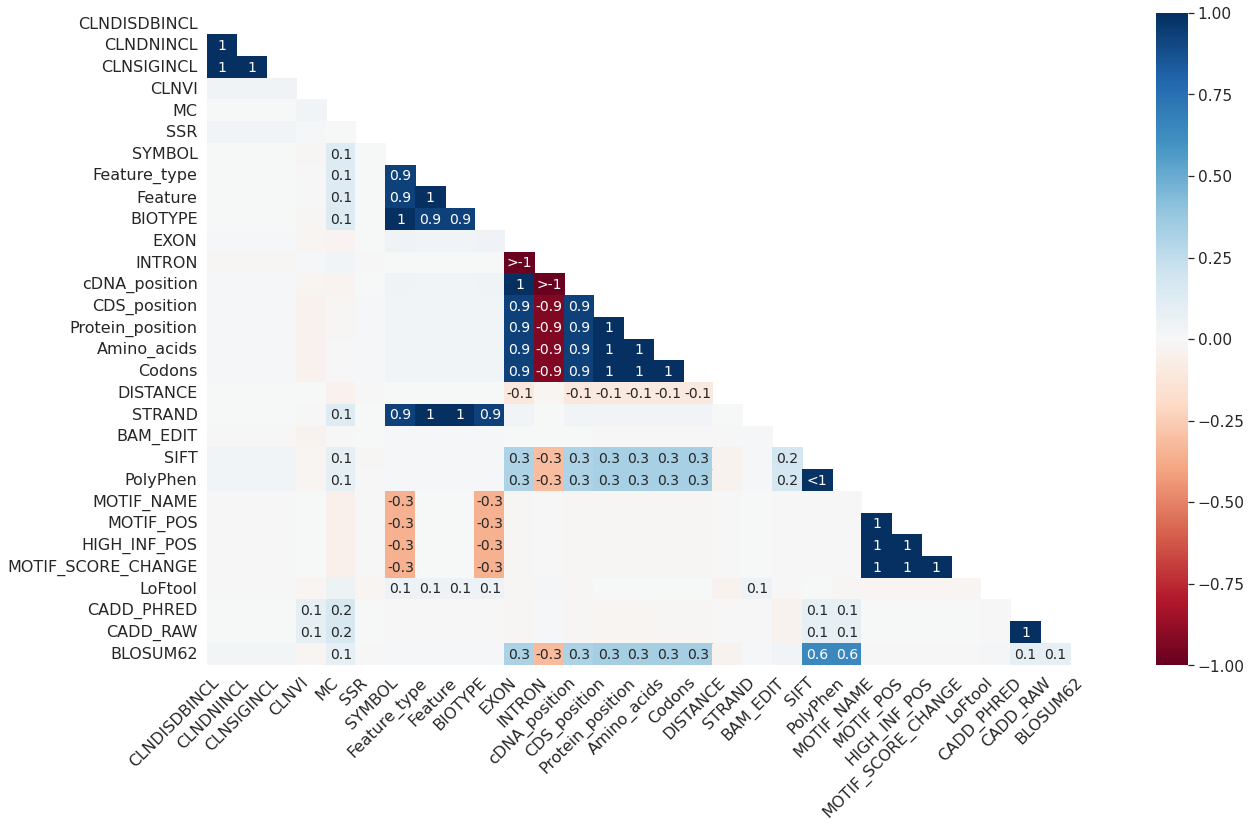

In [ ]:
# Visualize percentage of missing values in columns in relation with each other
msno.heatmap(df_nulls);

Initially, we will remove all columns with percentage of missing values > 50% if the modeling accuracy was bad, or if we gained a better insight into the data we will update this value or use a different approach.

In [ ]:
#Drop columns with missing values larger than 50%
drop = list(missing_values_perc[missing_values_perc['Percentage of Missing'] >= 50].index)
df.drop(drop ,axis = 1, inplace=True)

In [ ]:
df.shape

(65188, 31)

In [ ]:
#df['POS'].value_counts()
#df['AF_ESP'].value_counts()
#df['CADD_RAW'].value_counts()

In [ ]:
df['CLASS'] = df['CLASS'].astype('str')
df['OORIGIN'] = df['ORIGIN'].astype('str')
df['STRAND'] = df['STRAND'].astype('str')

numericals = df[['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP',
       'LoFtool', 'CADD_RAW']]

numericals.isnull().sum()

POS            0
AF_ESP         0
AF_EXAC        0
AF_TGP         0
LoFtool     4213
CADD_RAW    1092
dtype: int64

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Imputing Numerical Columns With Mean

for x in ["CADD_PHRED", "LoFtool", "CADD_RAW"]:
  df[x].fillna(df[x].mean(), inplace=True)

In [ ]:
# Imputing Categorical Columns With Mode

for x in ["MC", "SYMBOL", "Feature_type", "Feature", 
          "BIOTYPE", "STRAND", "Amino_acids", "EXON",
          "Codons", "cDNA_position", "CDS_position", "Protein_position"]:
    df[x].fillna(df[x].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

CHROM               0
POS                 0
REF                 0
ALT                 0
AF_ESP              0
AF_EXAC             0
AF_TGP              0
CLNDISDB            0
CLNDN               0
CLNHGVS             0
CLNVC               0
MC                  0
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL              0
Feature_type        0
Feature             0
BIOTYPE             0
EXON                0
cDNA_position       0
CDS_position        0
Protein_position    0
Amino_acids         0
Codons              0
STRAND              0
LoFtool             0
CADD_PHRED          0
CADD_RAW            0
OORIGIN             0
dtype: int64

### *Duplicates*

In [ ]:
df.duplicated().sum()

0

### *Correlation*

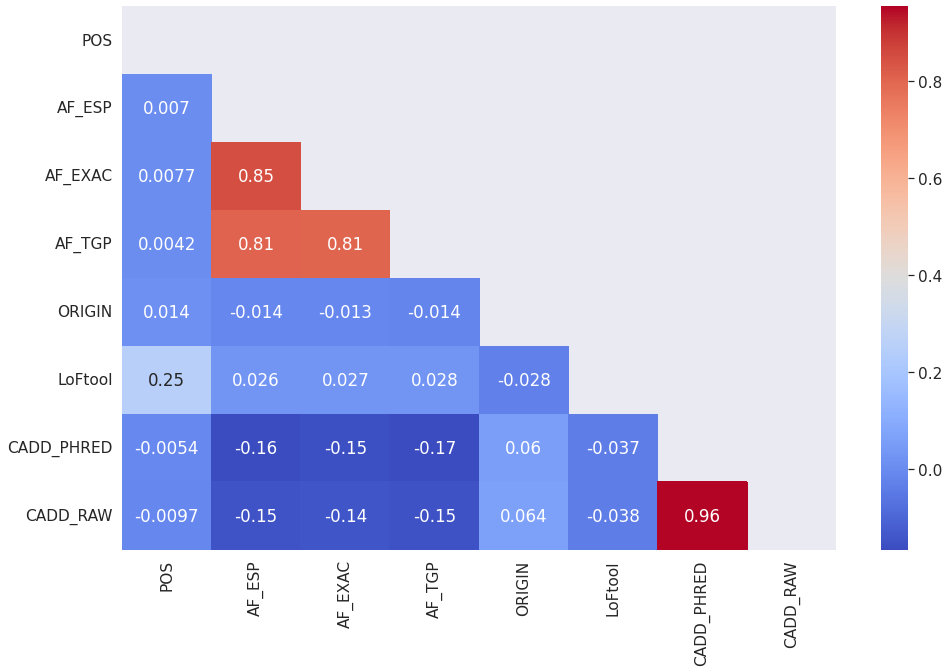

In [ ]:
plt.figure(figsize = (16,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), cmap="coolwarm", mask = matrix, annot=True);

In [ ]:
# Top 10 correlated pairs sorted
c = df.corr().abs()
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))[0:10]

sol

CADD_PHRED  CADD_RAW      0.955003
AF_ESP      AF_EXAC       0.851870
            AF_TGP        0.807741
AF_EXAC     AF_TGP        0.805634
POS         LoFtool       0.250507
AF_TGP      CADD_PHRED    0.166964
AF_ESP      CADD_PHRED    0.164081
AF_EXAC     CADD_PHRED    0.154813
AF_TGP      CADD_RAW      0.150904
AF_ESP      CADD_RAW      0.148038
dtype: float64

CADD_PHRED is a derived feature of CADD_RAW, so we'll remove it.

* CADD_RAW: Score of the deleteriousness of variants

* CADD_PHRED: Phred-scaled CADD score.


Given that these 3 columns represent data taken from different databases, even if 80% are mutual, given the sensetivity of the topic, and that most pathogenic variants are considered rare, we'll keep all three columns.

* AF_TGP: Allele frequency from 1000 genome project

* AF_ESP: Allele frequency from Exome Sequencing Project.

* AF_EXAC: Allele frequency from Exom Aggregation Consortium database

In [ ]:
df.drop('CADD_PHRED', axis = 1, inplace = True)

In [ ]:
df.shape

(65188, 31)

### *Outliers*

#### *First check for noise or any data entry errors*

In [ ]:
# create percentage bar charts (check github) for every variable
# check if there are any data entry errors

# Filter Numerical and Categorical columns
df_num = df.select_dtypes('number')
df_cat = df.select_dtypes(['object'])

print("The categorical columns are: \n", df_cat.columns, '\n')
print("The numerical columns are: \n", df_num.columns)

The categorical columns are: 
 Index(['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'CLASS', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type',
       'Feature', 'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position',
       'Protein_position', 'Amino_acids', 'Codons', 'STRAND', 'OORIGIN'],
      dtype='object') 

The numerical columns are: 
 Index(['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'ORIGIN', 'LoFtool', 'CADD_RAW'], dtype='object')


* CHROM: Chromosome that the variant is located on. 
Typical range of values 1-22, X,Y.
It also has the mitochondrial (mt) chromosome which contains genes involved in the process of oxidative phosphorylation — the production and storage of energy.

In [ ]:
df['CHROM'].value_counts()

2     8166
17    4918
11    4719
1     4454
5     3643
16    3586
19    3513
7     2867
9     2744
13    2515
12    2447
10    2341
6     2159
X     1926
8     1852
14    1755
3     1579
15    1557
4     1206
22    1043
3      950
18     785
21     724
20     682
2      479
17     476
19     398
16     341
12     303
14     219
15     168
13     131
11     127
21     119
18     111
22      92
20      77
MT      16
Name: CHROM, dtype: int64

* REF: Reference allele is the allele that is found in the reference genome(reference genome is a collection of genetic codes that scientist collected and studied and used for reference)

In [ ]:
df['REF'].value_counts()

C                          21798
G                          21361
A                           9845
T                           9421
CT                           126
                           ...  
CACAAACCT                      1
AGGTGAGCG                      1
GGTCTCTTA                      1
GGGAGGCGGGGACACCAGGGCCT        1
GGTGT                          1
Name: REF, Length: 866, dtype: int64

* ALT: The genes that are collected from the sample that we are studying and we don't know if they cause a disease.


In [ ]:
df['ALT'].value_counts()

T         20409
A         20205
G         11782
C         11429
TA          118
          ...  
GTG           1
CCGAGG        1
CAGGA         1
AAAAAC        1
CTAT          1
Name: ALT, Length: 458, dtype: int64

In [ ]:
#@title Default title text
# df['CLNDN'].value_counts()
# df['CLNDISDB'].value_counts()[:20]
# df['CLNHGVS'].value_counts() 
# df['CLNVC'].value_counts()
# df['MC'].value_counts()
# df['Allele'].value_counts()
# df['Consequence'].value_counts()
# df['IMPACT'].value_counts()
# df['SYMBOL'].value_counts()
# df['Feature_type'].value_counts()
# df['Feature'].value_counts()
# df['BIOTYPE'].value_counts()
# df['EXON'].value_counts()[:100]
# df['cDNA_position'].value_counts()
# df['CDS_position'].value_counts()
# df['Protein_position'].value_counts()
# df['Amino_acids'].value_counts()
# df['Codons'].value_counts()

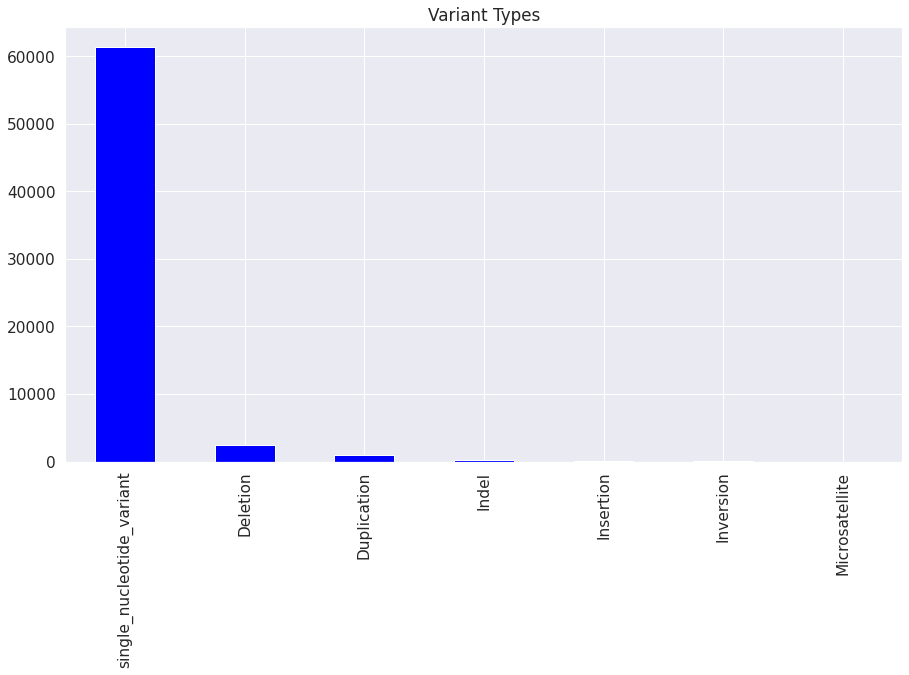

In [ ]:
df['CLNVC'].value_counts().plot(kind = 'bar', color = 'Blue', title = 'Variant Types');

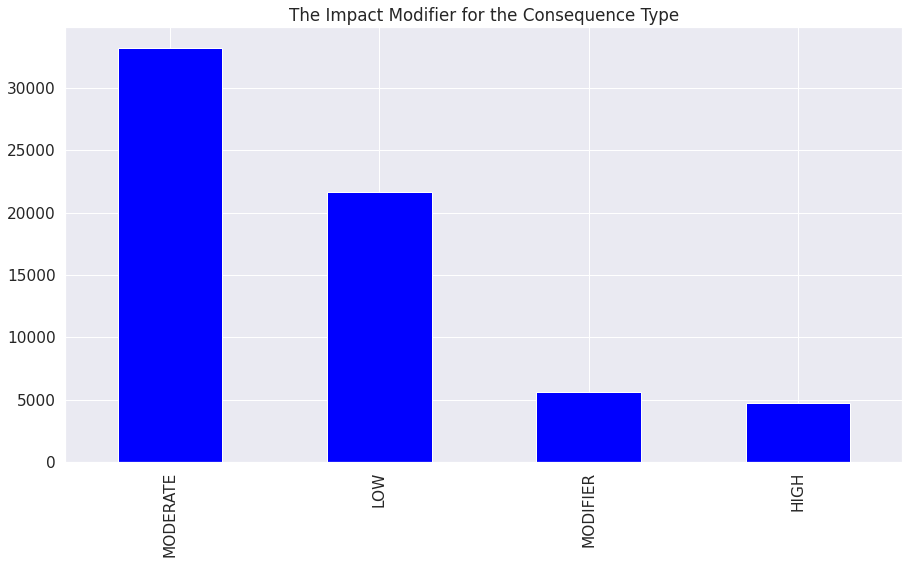

In [ ]:
df['IMPACT'].value_counts().plot(kind = 'bar', color = 'Blue', title = 'The Impact Modifier for the Consequence Type');

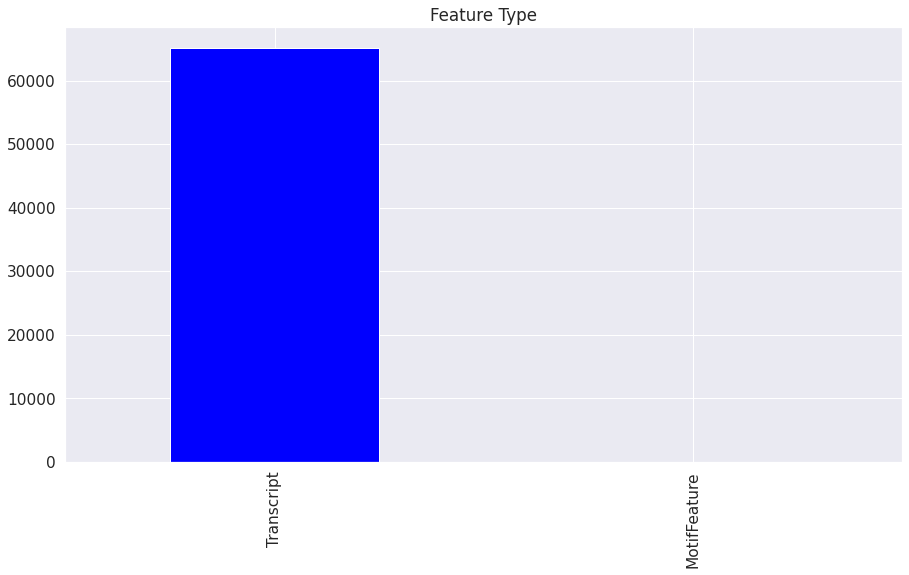

In [ ]:
df['Feature_type'].value_counts().plot(kind = 'bar', color = 'Blue', title = 'Feature Type')

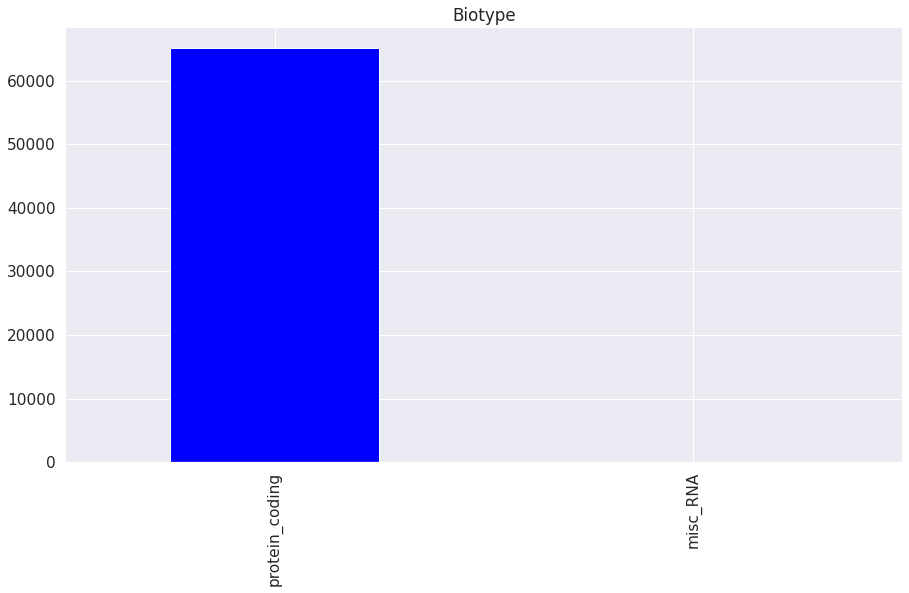

In [ ]:
df['BIOTYPE'].value_counts().plot(kind = 'bar', color = 'Blue', title = 'Biotype')

No data entry errors were found.

#### *Outlier Detection*

In [ ]:
import plotly.express as px
for column in df[["LoFtool", "CADD_RAW"]]:
  fig = px.box(df, y=column)
  fig.show()

Given the nature of the problem, we will not remove the outliers.

### Label Encoding

In [ ]:
categ = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'POS']

df[categ] = df[categ].astype('str')
df.dtypes

CHROM                object
POS                  object
REF                  object
ALT                  object
AF_ESP              float64
AF_EXAC             float64
AF_TGP              float64
CLNDISDB             object
CLNDN                object
CLNHGVS              object
CLNVC                object
MC                   object
ORIGIN                int64
CLASS                object
Allele               object
Consequence          object
IMPACT               object
SYMBOL               object
Feature_type         object
Feature              object
BIOTYPE              object
EXON                 object
cDNA_position        object
CDS_position         object
Protein_position     object
Amino_acids          object
Codons               object
STRAND               object
LoFtool             float64
CADD_RAW            float64
OORIGIN              object
dtype: object

In [ ]:
# Label Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df[categ] = df[categ].apply(labelencoder.fit_transform)
df

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,CLNVC,MC,ORIGIN,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,STRAND,LoFtool,CADD_RAW,OORIGIN
0,0,7559,437,106,0.0771,0.10020,0.1066,8866,8960,326,6,19,1,0,88,17,2,200,1,1700,1,0,8896,8316,1455,257,1653,1.0,0.345058,-0.208682,1
1,0,14560,437,0,0.0000,0.00000,0.0000,6615,8388,467,6,19,1,0,1,17,2,2135,1,463,1,2037,8470,8140,1381,756,1143,-1.0,0.345058,6.517838,1
2,0,18836,0,213,0.0000,0.00001,0.0000,750,8449,1179,6,24,35,1,168,17,2,892,1,849,1,2657,9963,3998,6814,480,813,-1.0,0.345058,6.061752,35
3,0,25485,437,0,0.0000,0.00000,0.0000,5993,8156,1826,6,19,33,0,1,17,2,1889,1,1893,1,53,1616,4,4579,377,523,1.0,0.345058,3.114491,33
4,0,25485,437,335,0.0000,0.00000,0.0000,5989,8154,1827,6,19,33,0,296,17,2,1889,1,1893,1,53,1616,4,4579,362,525,1.0,0.345058,4.766224,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,23,16644,644,213,0.0801,0.13923,0.1605,3195,3915,64090,6,89,1,0,168,46,1,707,1,63,1,431,6753,6393,566,968,2083,-1.0,0.001580,-0.630908,1
65184,23,16647,224,335,0.0020,0.00060,0.0013,8932,9085,64093,6,19,1,1,296,17,2,707,1,63,1,431,5343,4995,7289,1154,535,-1.0,0.001580,-1.731470,1
65185,23,16652,224,335,0.0125,0.00370,0.0111,8932,9085,64096,6,89,1,0,296,46,1,707,1,63,1,3053,1359,656,4928,78,1753,-1.0,0.001580,1.412434,1
65186,23,16657,644,106,0.0003,0.00034,0.0000,8221,6683,64097,6,89,1,0,88,46,1,1711,1,1796,1,832,12153,8625,1613,1070,885,-1.0,0.345058,-0.592415,1


### Class Imbalance

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(df)

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,CLNVC,MC,ORIGIN,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,STRAND,LoFtool,CADD_RAW,OORIGIN
0,0.0,7559.0,437.0,106.0,0.0771,0.10020,0.1066,8866.0,8960.0,326.0,6.0,19.0,1.0,0.0,88.0,17.0,2.0,200.0,1.0,1700.0,1.0,0.0,8896.0,8316.0,1455.0,257.0,1653.0,1.0,0.345058,-0.208682,1.0
1,0.0,14560.0,437.0,0.0,0.0000,0.00000,0.0000,6615.0,8388.0,467.0,6.0,19.0,1.0,0.0,1.0,17.0,2.0,2135.0,1.0,463.0,1.0,2037.0,8470.0,8140.0,1381.0,756.0,1143.0,-1.0,0.345058,6.517838,1.0
2,0.0,18836.0,0.0,213.0,0.0000,0.00001,0.0000,750.0,8449.0,1179.0,6.0,24.0,35.0,1.0,168.0,17.0,2.0,892.0,1.0,849.0,1.0,2657.0,9963.0,3998.0,6814.0,480.0,813.0,-1.0,0.345058,6.061752,35.0
3,0.0,25485.0,437.0,0.0,0.0000,0.00000,0.0000,5993.0,8156.0,1826.0,6.0,19.0,33.0,0.0,1.0,17.0,2.0,1889.0,1.0,1893.0,1.0,53.0,1616.0,4.0,4579.0,377.0,523.0,1.0,0.345058,3.114491,33.0
4,0.0,25485.0,437.0,335.0,0.0000,0.00000,0.0000,5989.0,8154.0,1827.0,6.0,19.0,33.0,0.0,296.0,17.0,2.0,1889.0,1.0,1893.0,1.0,53.0,1616.0,4.0,4579.0,362.0,525.0,1.0,0.345058,4.766224,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,23.0,16644.0,644.0,213.0,0.0801,0.13923,0.1605,3195.0,3915.0,64090.0,6.0,89.0,1.0,0.0,168.0,46.0,1.0,707.0,1.0,63.0,1.0,431.0,6753.0,6393.0,566.0,968.0,2083.0,-1.0,0.001580,-0.630908,1.0
65184,23.0,16647.0,224.0,335.0,0.0020,0.00060,0.0013,8932.0,9085.0,64093.0,6.0,19.0,1.0,1.0,296.0,17.0,2.0,707.0,1.0,63.0,1.0,431.0,5343.0,4995.0,7289.0,1154.0,535.0,-1.0,0.001580,-1.731470,1.0
65185,23.0,16652.0,224.0,335.0,0.0125,0.00370,0.0111,8932.0,9085.0,64096.0,6.0,89.0,1.0,0.0,296.0,46.0,1.0,707.0,1.0,63.0,1.0,3053.0,1359.0,656.0,4928.0,78.0,1753.0,-1.0,0.001580,1.412434,1.0
65186,23.0,16657.0,644.0,106.0,0.0003,0.00034,0.0000,8221.0,6683.0,64097.0,6.0,89.0,1.0,0.0,88.0,46.0,1.0,1711.0,1.0,1796.0,1.0,832.0,12153.0,8625.0,1613.0,1070.0,885.0,-1.0,0.345058,-0.592415,1.0


In [ ]:
for i in range(2):
  df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
  clean_dataset(df)
  df.CLASS = df.CLASS.astype(int)
  df.AF_ESP = df.AF_ESP.astype(int)
  df.AF_EXAC = df.AF_EXAC.astype(int)
  df.AF_TGP = df.AF_TGP.astype(int)
  df.STRAND = df.STRAND.astype(float)
  clean_dataset(df)
  df.STRAND = df.STRAND.astype(int)
  df.LoFtool = df.STRAND.astype(int)
  df.CADD_RAW = df.CADD_RAW.astype(int)
  df.OORIGIN = df.OORIGIN.astype(int)
  clean_dataset(df)
  print(df.dtypes)

CHROM               int64
POS                 int64
REF                 int64
ALT                 int64
AF_ESP              int64
AF_EXAC             int64
AF_TGP              int64
CLNDISDB            int64
CLNDN               int64
CLNHGVS             int64
CLNVC               int64
MC                  int64
ORIGIN              int64
CLASS               int64
Allele              int64
Consequence         int64
IMPACT              int64
SYMBOL              int64
Feature_type        int64
Feature             int64
BIOTYPE             int64
EXON                int64
cDNA_position       int64
CDS_position        int64
Protein_position    int64
Amino_acids         int64
Codons              int64
STRAND              int64
LoFtool             int64
CADD_RAW            int64
OORIGIN             int64
dtype: object
CHROM               int64
POS                 int64
REF                 int64
ALT                 int64
AF_ESP              int64
AF_EXAC             int64
AF_TGP              int6

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X = df.drop('CLASS', axis = 1)
y = df['CLASS']
clean_dataset(X)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_resampled.dropna(axis=0, how='any', inplace=True)
y_resampled.dropna(axis=0, how='any', inplace=True)

In [ ]:
y_resampled.value_counts()

1    48749
0    48749
Name: CLASS, dtype: int64

Text(0.5, 1.0, 'Benign vs. Pathogenic Class Count After Oversampling\n')

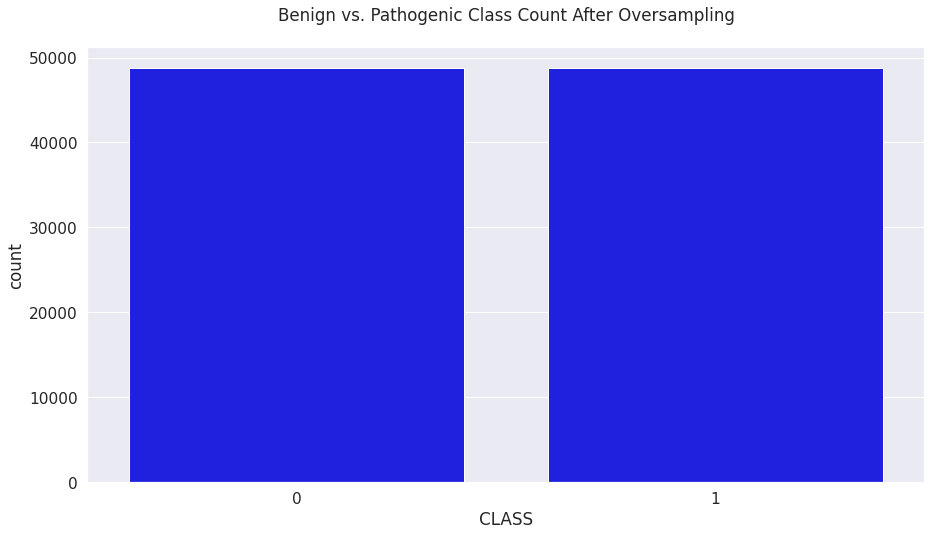

In [ ]:
sns.countplot(x = y_resampled, color = 'blue').set_title('Benign vs. Pathogenic Class Count After Oversampling\n')

In [ ]:
X_resampled.to_csv("X", index = False)
y_resampled.to_csv("y", index = False)

# *Modelling* 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
scaled = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
NB_alldata=gnb.predict(X_test)

print(confusion_matrix(y_test, NB_alldata))
print(classification_report(y_test, NB_alldata))

[[9538 6589]
 [9950 6098]]
              precision    recall  f1-score   support

           0       0.49      0.59      0.54     16127
           1       0.48      0.38      0.42     16048

    accuracy                           0.49     32175
   macro avg       0.49      0.49      0.48     32175
weighted avg       0.49      0.49      0.48     32175



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



In [ ]:
from sklearn import metrics
svc = SVC(gamma='auto')
svc.fit(scaled, y_train)
y_predict = svc.predict(X_test_std)
print("Accuracy score %.3f" %metrics.accuracy_score(y_test, y_predict))

## Ensembling

**Cross Validate Models**

We will compare 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

- SVC
- Decision Tree
- AdaBoost
- XGBoost
- Random Forest
- Extra Trees
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [ ]:
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



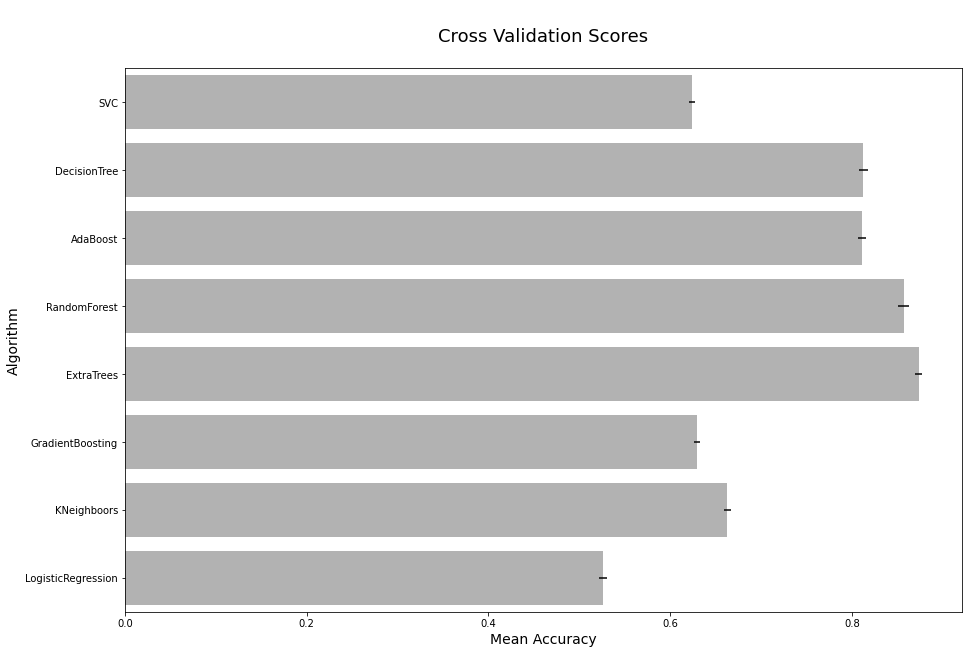

In [ ]:
random_state = 42

classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.01))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_std, y = y_train, scoring = "accuracy", cv = 10, n_jobs=4, error_score = 'raise'))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression"]})

plt.figure(figsize=(15, 10))

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, color="grey",orient = "h",**{'xerr':cv_std}, alpha = 0.6);
g.set_xlabel("Mean Accuracy", size = 14);
g.set_ylabel("Algorithm", size = 14);
g = g.set_title("\nCross Validation Scores\n", size = 18);
plt.savefig('CVModelScores.png', dpi=300, bbox_inches='tight')


In [ ]:
cv_res.sort_values(by = 'CrossValMeans', ascending = False)

,CrossValMeans,CrossValerrors,Algorithm
4,0.873613,0.003808,ExtraTrees
3,0.857171,0.006076,RandomForest
1,0.812868,0.004730,DecisionTree
2,0.811169,0.003999,AdaBoost
6,0.662814,0.003822,KNeighboors
5,0.629916,0.003505,GradientBoosting
0,0.623915,0.003548,SVC
7,0.526598,0.004472,LogisticRegression


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {
              "max_features": [3, 10, 20],
              "n_estimators" :[100,300, 500],
              "criterion": ["gini", "entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(scaled,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print(RFC_best.best_score_)
# pickle.dump(RFC_best, open('randomforestmodel.sav', 'wb'))

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "n_estimators" :[100,300, 400],
              "criterion": ["gini", "entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(scaled,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print(ExtC_best.best_score_)
# pickle.dump(ExtC_best, open('extratreesmodel.sav', 'wb'))

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[10, 50, 100, 150],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(scaled,y_train)

ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)
pickle.dump(ada_best, open('adamodel.sav', 'wb'))

In [ ]:
# Decision Tree
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : range(20,50),
              'min_samples_split': range(2,15),
              'min_samples_leaf': range(1,10),
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, n_jobs = 4, param_grid=param_grid, verbose=True)
grid_search.fit(scaled, y_train)

dt_best = grid_search.best_estimator_
#to read the model
# model = pickle.load(open('model', 'rb'))
# res = model.score(X_test, y_test)
# resr_

print(grid_search.best_params_)
print(grid_search.best_score_)
pickle.dump(dt_best, open('dtsmodel.sav', 'wb'))

In [ ]:
y_test = y_test.astype(str)
y_test.dtype

dtype('O')

In [ ]:
import pickle
RFC_best = pickle.load(open('/content/drive/MyDrive/DMProject/randomforestmodel.sav', 'rb'))
res1 = RFC_best.score(X_test, y_test)

ExtC_best = pickle.load(open('/content/drive/MyDrive/DMProject/extratreesmodel.sav', 'rb'))
res2 = ExtC_best.score(X_test, y_test)

ada_best = pickle.load(open('/content/drive/MyDrive/DMProject/adamodel.sav', 'rb'))
res3 = ada_best.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but ExtraTreesClassifier was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature na

In [ ]:
print(res1, res2, res3)

0.8777622377622377 0.5012276612276613 0.4996736596736597


In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('adac',ada_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

In [ ]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
print(f'{votingC} Training Score: {votingC.score(scaled, y_train)}')
print(f'{votingC} Testing Score: {votingC.score(X_test, y_test)}')
print()
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names



VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_features=3,
                                                     n_estimators=500)),
                             ('extc',
                              ExtraTreesClassifier(max_features=1,
                                                   min_samples_split=3,
                                                   n_estimators=400)),
                             ('adac',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 base_estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.001,
                                                 n_estimators=10))],
                 n_jobs=-1, voting='soft') Training Score: 0.4993953125239196
VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_features=3,
                                                     n

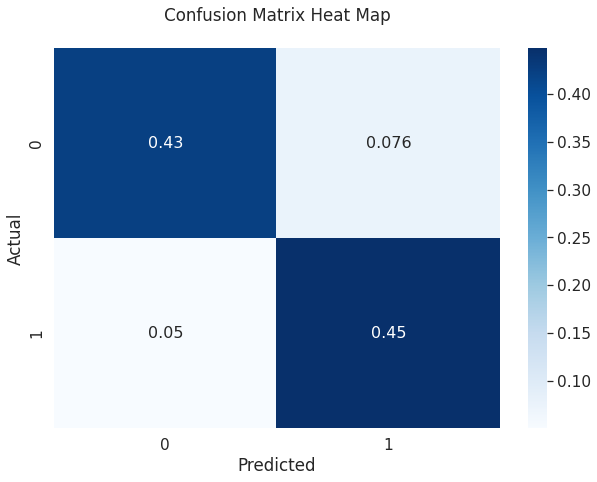

In [ ]:
data = confusion_matrix(y_test, y_pred, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')